In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from nltk.stem.snowball import SnowballStemmer
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import re

In [60]:
dataset_path = './archive/train.csv'
data_column  = 'tweet'
SVM			 = True

In [61]:
df = pd.read_csv(dataset_path)

In [62]:
def reduce_repetition(s):
    # Use regular expression to find repeated substrings
    pattern = re.compile(r'(.+?)\1{%d,}' % 2)
    match = pattern.search(s)

    # Reduce repetition to two occurrences
    while match:
        repeated_substring = match.group(1)
        s = s.replace(match.group(), repeated_substring, 1)
        match = pattern.search(s)

    return s

In [63]:
abbr = {
    'ninstagram'        : 'instagram',
    'instagramgram'     : 'instagram',
    'ig'                : 'instagram',
    'strainstagramht'   : 'instagram',
    'insta'             : 'instagram',
    'rinstagramht'      : 'instagram',
    'ninstagramguh'     : 'instagram',
    'instagramz'        : 'instagram',
    'sinstagramn'       : 'instagram',
    'binstagramgest'    : 'instagram',
    'pinstagram'        : 'instagram',
    'linstagramht'      : 'instagram',
    'ninstagramg'       : 'instagram',
    'instagramh'        : 'instagram',
    'instagramnor'      : 'instagram',
    'ninstagramht'      : 'instagram',
    'ninstagramgramga'  : 'instagram',
    'finstagramht'      : 'instagram',
    'binstagram'        : 'instagram',
    'hinstagramh'       : 'instagram',
    'ninstagramga'      : 'instagram',
    'toninstagramht'    : 'instagram',
    'minstagramht'      : 'instagram',
    'minstagramt'       : 'instagram',
    'dwn'               : 'down',
    'dawn'              : 'down',
    'ta'                : 'that',
    'dat'               : 'that',
    'dawg'              : 'dude',
    'smh'               : 'head',
    'fr'                : 'real',
    'plz'               : 'please',
    'tf'                : 'wtf',
    'theyr'             : 'are',
    'bc'                : 'because',
    'af'                : 'lot',
    'u'                 : 'you',
    'ppl'               : 'people',
    'dm'                : 'message',
    'bf'                : 'friend',
    'gt'                : 'getting',
    'ya'                : 'yes',
    'na'                : 'no',
    'ur'                : 'your',
    'tryna'             : 'to',
    'lmfao'             : 'lmao',
    'ive'               : 'have'
}

In [64]:
def remove_points(line):
    l = list(line)

    for i in range(len(l)):
        if i < len(l) - 2 and l[i] == '.' and 'A' <= l[i+2] <= 'Z':
            l[i] = ' '

    line = ' '.join(l)

In [65]:
stemmer = SnowballStemmer('english')

In [66]:
def preprocess(sentence, get='stems'):
    sent = re.sub(r'@([a-zA-Z0-9_]+)', 'username', sentence).replace('username:', '') # replace first username
    sent = re.sub(r'http?://\S+', 'weblink', sent)
    sent = re.sub(r'&amp', '&', sent)

    if sent and sent[0] == '.':
        sent = sent[1:]

    remove_points(sent)
    sent = sent   .replace('RT', '').replace('!', ' ').replace('"', '').replace("\n", ' ')\
                        .replace(';', ' ').replace('-', ' ').replace(' and ', ' & ').replace('\'', '')\
                        .replace('?', '.').replace(',', '').replace('~', ' ').replace('|', ' ').replace('°', ' ')\
                        .replace('`', ' ').replace('~', ' ').replace('*', ' ').replace('+', ' ').replace('/', ' ')\
                        .replace(' # ', ' ').replace('http', ' ').replace('t.co', ' ').replace('\\', ' ').replace('&#', ' ')
    for _ in range(4):
        sent = sent.replace('  ', ' ').replace('..', '.').replace(' .', '.') # remove multiple points & space
    
    if sent and sent[0] == ' ':
        sent = sent[1:]

    sent = sent.lower()

    for old in abbr:
        new = abbr[old]
        sent = sent.replace( ' ' + old + ' ', ' ' + new + ' ' ) # add some space arround the world to avoid matching a part of a word

    sent = reduce_repetition(sent)

    if get == 'sentence':
        return sent
    
    tokens = nltk.word_tokenize(sent)

    for i in range(len(tokens) - 1, 0, -1):
        if len(tokens[i].strip()) == 0 or (len(tokens[i].strip()) == 1 and tokens[i].strip() != 'a' and tokens[i].strip() != 'i' and tokens[i].strip() != '&'):
            tokens.pop(i)

    if get == 'tokens':
        return tokens

    stems = []

    for tok in tokens:
        stems.append(stemmer.stem(tok))

    for i in range(len(stems) - 1, 0, -1):
        if len(stems[i].strip()) == 0:
            stems.pop(i)
        elif len(stems[i].strip()) == 1:
            if 'a' < stems[i].strip() <= 'z'and stems[i].strip() != 'i':
                stems.pop(i)


    for i in range(len(stems) - 1, 0, -1):
        arr = stems[i].split('.')
        stems[i] = arr[0]
        for j in range(1, len(arr)):
            stems.insert(i+j, arr[j])

    for i in range(len(stems)):
        if stems[i] in abbr.keys():
            stems[i] = abbr[stems[i]]

    return stems

In [67]:
df['processed_text'] = df[data_column].apply(preprocess)

In [68]:
df['processed_text_str'] = df['processed_text'].apply(lambda x: " ".join(x))

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text_str']).toarray()

In [69]:
def label_tweet(row):
    """
    - Hate: If hate_speech_count is the highest count.
    - Offensive: If offensive_language_count is the highest count.
    - Hate & Offensive: If hate_speech_count and offensive_language_count are equal and higher than neither_count.
    - Neither: If neither_count is the highest count.
    """
    if row['hate_speech_count'] > row['offensive_language_count'] and row['hate_speech_count'] > row['neither_count']:
        return 'hate'
    elif row['offensive_language_count'] > row['hate_speech_count'] and row['offensive_language_count'] > row['neither_count']:
        return 'hate'
    elif row['hate_speech_count'] == row['offensive_language_count'] and row['hate_speech_count'] > row['neither_count']:
        return 'hate'
    else:
        return 'neither'

In [70]:
df['label'] = df.apply(label_tweet, axis=1)

In [71]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

In [72]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'hate': 0, 'neither': 1}


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

**Logistic Regression** Model

In [74]:
logistic_model = LogisticRegression(max_iter=5000)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [75]:
logistic_predictions = logistic_model.predict(X_test)

**SVM** Model

In [78]:
if SVM:
	svm_model = SVC()
	svm_model.fit(X_train, y_train)
	svm_predictions = svm_model.predict(X_test)

In [86]:
# Evaluation function
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

In [87]:
# Evaluating the models
logistic_eval = evaluate_model(y_test, logistic_predictions)
if SVM: svm_eval = evaluate_model(y_test, svm_predictions)

print("Logistic Regression - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(*logistic_eval))
if SVM: print("SVM - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(*svm_eval))

Logistic Regression - Accuracy: 0.94, Precision: 0.94, Recall: 0.94, F1 Score: 0.94
SVM - Accuracy: 0.95, Precision: 0.95, Recall: 0.95, F1 Score: 0.95


In [88]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(	j, i, format(cm[i, j], fmt),
					horizontalalignment="center",
					color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix


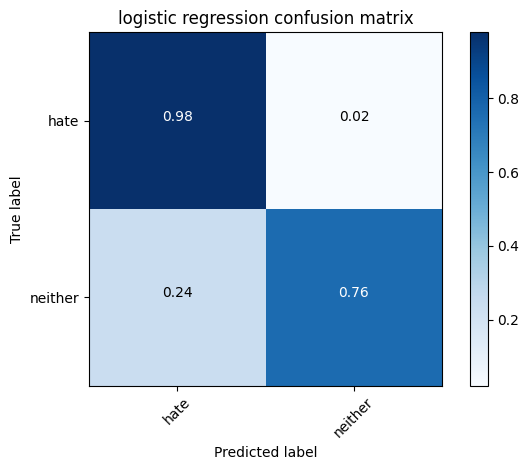

In [89]:
plot_confusion_matrix(y_test, logistic_predictions, classes=label_mapping.keys(), normalize=True, title='logistic regression confusion matrix')

Normalized confusion matrix


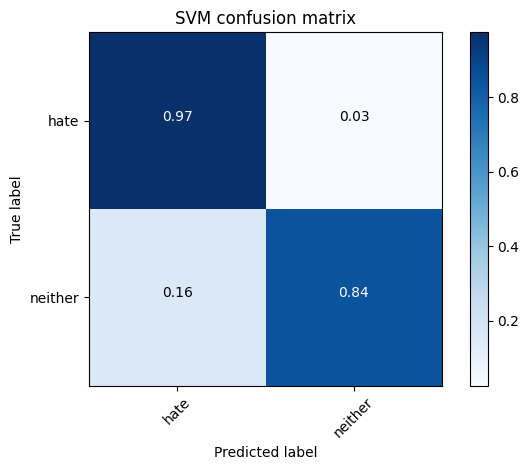

In [90]:
if SVM: plot_confusion_matrix(y_test, svm_predictions, classes=label_mapping.keys(), normalize=True, title='SVM confusion matrix')

In [91]:
test = [
    "This restaurant is not worth your time or money.",
    "Your work has been consistently outstanding.",
    "He has a very controversial opinion on that.",
    "I'm offended by your generalizations about people.",
    "The team's performance was embarrassingly poor this season.",
    "Your statement is ignorant and deeply offensive.",
    "It's irresponsible to spread such misinformation.",
    "The book was a groundbreaking piece of literature.",
    "Their approach to problem-solving is quite innovative.",
    "That comment was uncalled for and hurtful.",
    "Your dedication to this project is truly inspiring.",
    "I disagree with your methods and results.",
    "The movie's plot was predictable and unoriginal.",
    "Your assistance has been invaluable to our success.",
    "Their political stance is quite extreme and divisive.",
    "I've never experienced such terrible customer service.",
    "Your creativity and vision are truly exceptional.",
    "That joke was in poor taste and offensive.",
    "The way they handle issues is highly professional.",
    "I find your lack of empathy disturbing.",
    "This new policy could be detrimental to our progress.",
    "Your leadership has brought us to new heights.",
    "Such behavior is unacceptable and disappointing.",
    "Their perspective on this matter is refreshingly honest.",
    "I can't believe how narrow-minded that statement was.",
    "The quality of this product exceeded my expectations.",
    "That speech was inflammatory and reckless.",
    "Your contribution to the field is groundbreaking.",
    "They have a tendency to make baseless accusations.",
    "Her insight into the issue was incredibly enlightening.",
    "That remark was sexist and inappropriate.",
    "Your performance has consistently improved.",
    "Their lack of responsibility in this matter is alarming.",
    "I've never seen such a well-executed plan.",
    "That's an outdated and prejudiced viewpoint.",
    "Your innovative approach is exactly what we needed.",
    "His comments were racially insensitive.",
    "The service at this hotel is top-notch.",
    "Such ignorance about the topic is astounding.",
    "You have a talent for making complex topics accessible.",
    "Their accusations were baseless and harmful.",
    "The artwork you created was deeply moving.",
    "That kind of language is unacceptable and harmful.",
    "Your understanding of the subject is impressive.",
    "Their stance on the issue is misguided and naive.",
    "The attention to detail in this project is remarkable.",
    "Your statement was biased and unfounded.",
    "The innovation in this design is revolutionary.",
    "That kind of behavior should not be tolerated.",
    "You have an exceptional ability to motivate people.",
    "Their argument is flawed and poorly constructed.",
    "The craftsmanship of this product is exceptional.",
    "Such a disrespectful comment is unacceptable.",
    "Your ability to adapt to changes is commendable.",
    "They have a habit of spreading rumors.",
    "This painting is a masterpiece of modern art.",
    "That approach is overly simplistic and ineffective.",
    "Your problem-solving skills are extraordinary.",
    "Their remarks were homophobic and unacceptable.",
    "The level of skill in your work is astounding.",
    "That sort of attitude is counterproductive and harmful.",
    "Your vision for the project is innovative and exciting.",
    "They often make discriminatory remarks.",
    "This novel is a brilliant exploration of complex themes.",
    "That methodology is outdated and inefficient.",
    "Your insights have been crucial to our understanding.",
    "Their commentary is often sexist and degrading.",
    "The elegance of this design is unparalleled.",
    "That kind of talk is divisive and unhelpful.",
    "You have an impressive knack for leadership.",
    "They display a concerning lack of judgment.",
    "This sculpture is a stunning representation of abstract art.",
    "That opinion is short-sighted and uneducated.",
    "Your strategic planning has been a game-changer.",
    "Their views are often extremist and polarizing.",
    "The complexity of this issue has been well-handled.",
    "That statement is a gross oversimplification.",
    "You have a profound understanding of the topic.",
    "They frequently engage in unethical practices.",
    "This film is a remarkable achievement in cinema.",
    "That assumption is both arrogant and incorrect.",
    "Your ability to overcome obstacles is inspiring.",
    "They tend to be dismissive of important issues.",
    "The texture and color in this artwork are extraordinary.",
    "That kind of statement is fear-mongering.",
    "You've shown remarkable growth and development.",
    "Their handling of the situation was inept and careless.",
    "This song is an anthem for a generation.",
    "That view is narrow-minded and regressive.",
    "Your resilience in the face of adversity is admirable.",
    "They often resort to personal attacks.",
    "The innovation in this technology is groundbreaking.",
    "That kind of rhetoric is dangerous and misleading.",
    "You have a unique ability to connect with people.",
    "Their interpretation of the data is misleading.",
    "This artwork is a vivid portrayal of contemporary issues.",
    "That strategy is unethical and irresponsible.",
    "Your work ethic is unmatched and commendable.",
    "They frequently display a lack of empathy.",
    "This piece is a thought-provoking exploration of identity."
    ]

In [92]:
# 6. Preprocess the test sentences
preprocessed_test_sentences = [preprocess(sentence) for sentence in test]

# 7. Transform the test sentences to TF-IDF vectors
X_test_tfidf = tfidf_vectorizer.transform(preprocessed_test_sentences)

# 8. Make predictions using the logistic regression model
predictions = logistic_model.predict(X_test_tfidf)

# 9. Optionally, map the predictions back to labels if you're using label encoding
# label_mapping = {...}  # The mapping used in your training
# decoded_predictions = [label_mapping[pred] for pred in predictions]

# 10. Output the predictions
for sentence, prediction in zip(test, predictions):
    print(f"{sentence}\t{prediction}")


AttributeError: 'list' object has no attribute 'lower'